In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import time
from scipy.stats import norm

In [2]:
######################
# Auxiliary functions:
######################

def Wiener_proc(N, T):
    W = np.zeros(N)  
    delta = T / N
    sqrt_delta = np.sqrt(delta)    
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

# For the Euler-Maruyama approximation
# Geometric Brownian Motion process
def GBM(S, mu, sigma, dt, dW):
    dS = mu * S * dt + sigma * S * dW
    return dS

# Ornstein-Uhlenbeck process
def OU(S, theta, sigma, dt, dW):
    dS = -theta * S * dt + sigma * dW
    return dS

# Cox-Ingersoll-Ross process #theta 3 params
def CIR(S, kappa, theta, sigma, dt, dW):
    dS = (kappa - theta * S) * dt + sigma * np.sqrt(S) * dW
    return dS

# For the Milstein scheme
# Geomtric brownian Motion
def M_GBM(S, mu, sigma, dt, dW):
    dS = mu * S * dt + sigma * S * dW + (sigma**2) * S * ((dW**2) - dt) / 2
    return dS

# Ornstein-Uhlenbeck process
def M_OU(S, theta, sigma, dt, dW):
    dS = -theta * S * dt + sigma * dW
    return dS

# Cox-Ingersoll-Ross process #theta 3 params
def M_CIR(S, kappa, theta, sigma, dt, dW):
    dS = (kappa - theta * S) * dt + sigma * np.sqrt(S) * dW + (sigma**2) * ((dW**2) - dt) / 4 
    return dS

# For the Predictor-corrector method
# Geometric Brownian Motion process
def P_GBM(S, pS, mu, sigma, dt, dW, alpha, eta):
    baS  = mu * S - eta * (sigma**2) * S
    bapS = mu * pS - eta * (sigma**2) * pS
    dS = (alpha * bapS + (1 - alpha) * baS) * dt + (eta * sigma * pS + (1-eta) * sigma * S) * dW
    return dS

# Ornstein-Uhlenbeck process
def P_OU(S, pS, theta, sigma, dt, dW, alpha, eta):
    baS  = -theta * S
    bapS = -theta * pS
    dS = (alpha * bapS + (1-alpha) * bapS) * dt + (eta * sigma + (1 - eta) * sigma) * dW
    return dS

# Cox-Ingersoll-Ross process #theta 3 params
def P_CIR(S, pS, kappa, theta, sigma, dt, dW, alpha, eta):
    baS  = (kappa - theta * S) - eta * (sigma**2) / 2 
    bapS = (kappa - theta * pS) - eta * (sigma**2) / 2 
    dS = (alpha * bapS + (1 - alpha) * baS) * dt + (eta * sigma * np.sqrt(pS) + (1 - eta) * sigma * np.sqrt(S)) * dW
    return dS

# For the 2nd Milstein scheme
# Geomtric brownian Motion
def M2_GBM(S, mu, sigma, dt, dW):
    dS = S * (mu - (sigma**2)/2) * dt + sigma * S * dW + (sigma**2) * S * (dW**2)\
    + dt * dW * mu * S * sigma + S * (mu**2) * (dt**2) / 2
    return dS

# Ornstein-Uhlenbeck process
def M2_OU(S, theta, sigma, dt, dW):
    dS = - theta * S * dt + sigma * dW - theta * dt * dW / 2 + (theta**2) * S * (dt**2) / 2 
    return dS

# Cox-Ingersoll-Ross process #theta 3 params
def M2_CIR(S, kappa, theta, sigma, dt, dW):
    dS = (kappa - theta * S - (sigma**2)/4) * dt + sigma * np.sqrt(S) * dW + (dW**2) * (sigma**2) / 4 \
    + dt * dW * (sigma * (kappa - theta * S) / (4 * np.sqrt(S)) - theta * sigma * np.sqrt(S) / 2 - (sigma**3) / 4 / np.sqrt(S)) \
    - theta * (kappa - theta * S) * (dt**2) / 2
    return dS

# For the KPS-method approximation
# Geometric Brownian Motion process
def KPS_GBM(S, mu, sigma, dt, dW):
    ft = mu * S * dt + sigma * S * dW + (sigma**2) * S * (dW**2 - dt) / 2
    st = mu * sigma * S * rnd.normal(0, (dt**3) / 3) + (mu**2) * S * (dt**2)
    tt = mu * sigma * S * (dW * dt - rnd.normal(0, (dt**3) / 3))
    frt = S * (sigma**3) * ((dW**2)/3 - dt) * dW / 2
    dS = ft + st + tt + frt
    return dS

# Cox-Ingersoll-Ross process #theta 3 params
def KPS_CIR(S, kappa, theta, sigma, dt, dW):
    ft = (kappa - theta * S) * dt + sigma * np.sqrt(S) * dW + (sigma**3) * ((dW**2) - dt) / 4
    st = -theta * sigma * np.sqrt(S) * rnd.normal(0, (dt**3) / 3) + ((theta**2)*S - kappa * theta) * (dt**2) / 2
    tt = (kappa - theta * S) * sigma * (dW * dt - rnd.normal(0, (dt**3) / 3)) / 2 / np.sqrt(S)
    dS = ft + st + tt
    return dS

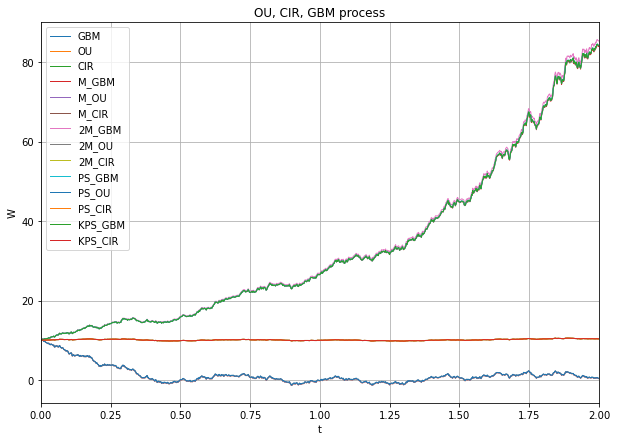

In [3]:
# Task 1:
# using Euler; 1st, 2nd Milstein schemes, predictor-corrector methods
# simulate and plot: OU, CIR, BSM

# Data:
N = 1000
T = 2
time_line, dt = np.linspace(0, T, N, retstep=True)
mu = 1
sigma = 0.2
alpha = 0.33
eta   = 0.25

# Generate common Wiener proces:
W  = Wiener_proc(N, T)
dW = 0

S_gbm, S_ou, S_cir = np.zeros(N), np.zeros(N), np.zeros(N)
PS_gbm, PS_ou, PS_cir = np.zeros(N), np.zeros(N), np.zeros(N)
MS_gbm, MS_ou, MS_cir = np.zeros(N), np.zeros(N), np.zeros(N)
M2S_gbm, M2S_ou, M2S_cir = np.zeros(N), np.zeros(N), np.zeros(N)
KPS_gbm, KPS_cir = np.zeros(N), np.zeros(N)

S_gbm[0], S_ou[0], S_cir[0] = 10, 10, 10
PS_gbm[0], PS_ou[0], PS_cir[0] = 10, 10, 10
MS_gbm[0], MS_ou[0], MS_cir[0] = 10, 10, 10
M2S_gbm[0], M2S_ou[0], M2S_cir[0] = 10, 10, 10
KPS_gbm[0], KPS_cir[0] = 10, 10

for i in range(1, N):
    dW = W[i] - W[i-1] 
    # Basic paths | the same as Euler method
    S_gbm[i] = S_gbm[i-1] + GBM(S_gbm[i-1], 1, 0.2, dt, dW)       # mu = 1, sigma = 0.2
    S_ou[i] = S_ou[i-1] + OU(S_ou[i-1], 5, 3.5, dt, dW)        # theta = 5, sigma = 10
    S_cir[i]  = S_cir[i-1] + CIR(S_cir[i-1], 2, 0.2, 0.15, dt, dW) # kappa = 2, theta = 0.2, sigma = 0.15
    
    # With the 1st Milstein scheme:
    MS_gbm[i] = MS_gbm[i-1] + M_GBM(MS_gbm[i-1], 1, 0.2, dt, dW)    
    MS_ou[i]  = MS_ou[i-1] + M_OU(MS_ou[i-1], 5, 3.5, dt, dW)
    MS_cir[i] = MS_cir[i-1] + M_CIR(MS_cir[i-1], 2, 0.2, 0.15, dt, dW)
    
    # With the 2nd Milstein scheme:
    M2S_gbm[i] = M2S_gbm[i-1] + M2_GBM(S_gbm[i-1], 1, 0.2, dt, dW)    
    M2S_ou[i]  = M2S_ou[i-1] + M2_OU(S_ou[i-1], 5, 3.5, dt, dW)
    M2S_cir[i] = M2S_cir[i-1] + M2_CIR(S_cir[i-1], 2, 0.2, 0.15, dt, dW)
    
    # With the Predictor-corrector method:
    PS_gbm[i] = PS_gbm[i-1] + P_GBM(PS_gbm[i-1], S_gbm[i], 1, 0.2, dt, dW, alpha, eta)
    PS_ou[i]  = PS_ou[i-1] + P_OU(PS_ou[i-1], S_ou[i], 5, 3.5, dt, dW, alpha, eta)
    PS_cir[i] = PS_cir[i-1] + P_CIR(PS_cir[i-1], S_cir[i], 2, 0.2, 0.15, dt, dW, alpha, eta)
    
    # KPS method
    KPS_gbm[i] = S_gbm[i-1] + KPS_GBM(KPS_gbm[i-1], 1, 0.2, dt, dW)
    KPS_cir[i]  = S_cir[i-1] + KPS_CIR(KPS_cir[i-1], 2, 0.2, 0.15, dt, dW)
    
    
# Plot figure
plt.figure ( figsize =(10, 7) )
plt.grid ()
# Basic paths (Euler)
plt.plot (time_line, S_gbm, linewidth =1.0, label="GBM")
plt.plot (time_line, S_ou, linewidth =1.0, label="OU")
plt.plot (time_line, S_cir, linewidth =1.0, label="CIR")
# The 1st Milstein scheme paths
plt.plot (time_line, MS_gbm, linewidth =1.0, label="M_GBM")
plt.plot (time_line, MS_ou, linewidth =1.0, label="M_OU")
plt.plot (time_line, MS_cir, linewidth =1.0, label="M_CIR")
# The 2nd Milstein cheme paths
plt.plot (time_line, M2S_gbm, linewidth =1.0, label="2M_GBM")
plt.plot (time_line, M2S_ou, linewidth =1.0, label="2M_OU")
plt.plot (time_line, M2S_cir, linewidth =1.0, label="2M_CIR")
# The Predictor-Corrector scheme paths
plt.plot (time_line, PS_gbm, linewidth =1.0, label="PS_GBM")
plt.plot (time_line, PS_ou, linewidth =1.0, label="PS_OU")
plt.plot (time_line, PS_cir, linewidth =1.0, label="PS_CIR")
# The KPS method paths
plt.plot (time_line, KPS_gbm, linewidth =1.0, label="KPS_GBM")
plt.plot (time_line, KPS_cir, linewidth =1.0, label="KPS_CIR")


plt.title ("OU, CIR, GBM process")
plt.xlabel ("t")
plt.ylabel ("W")
plt.legend()
plt.xlim(0, T)
plt.show ()

In [4]:
# GBM
def Mult_GBM(mu, sigma, t, W):
    return np.exp((mu - (sigma**2)/2)*t + sigma * W)

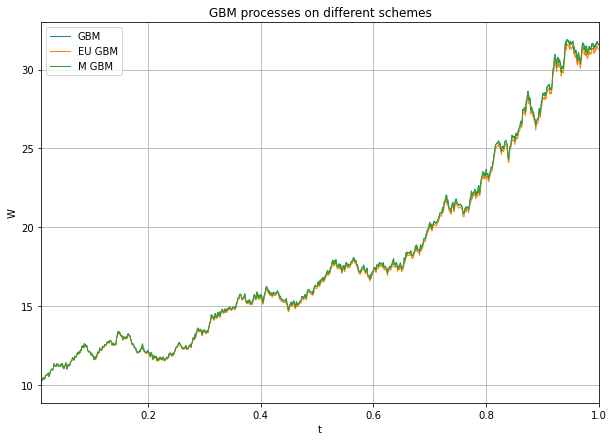

In [5]:
# Task 2
# Compare convergence of Euler and Milstein schemes with different dicretization step

# Data:
N = 1000
T = 1
time_line, dt = np.linspace(0, T, N, retstep=True)
mu = 1
sigma = 0.2
alpha = 0.33
eta   = 0.25

S_gbm, EUS_gbm, MS_gbm = np.zeros(N), np.zeros(N), np.zeros(N)
errEU, errM = np.zeros(N), np.zeros(N)
S_gbm[0], EUS_gbm[0], MS_gbm[0] = 10, 10, 10

for i in range(1, N):
    dW = W[i] - W[i-1]
    S_gbm[i]   = S_gbm[0] * Mult_GBM(mu, sigma, time_line[i], W[i])
    EUS_gbm[i] = EUS_gbm[i-1] + GBM(S_gbm[i-1], 1, 0.2, dt, dW)
    MS_gbm[i]  = MS_gbm[i-1] + M_GBM(MS_gbm[i-1], 1, 0.2, dt, dW)   
    errEU[i] = abs(S_gbm[i] - EUS_gbm[i])
    errM[i]  = abs(S_gbm[i] - MS_gbm[i])

    
# Plot figure
plt.figure ( figsize =(10, 7) )
plt.grid ()

plt.plot (time_line, S_gbm, linewidth =1.0, label="GBM")
plt.plot (time_line, EUS_gbm, linewidth =1.0, label="EU GBM")
plt.plot (time_line, MS_gbm, linewidth =1.0, label="M GBM")

plt.title ("GBM processes on different schemes")
plt.xlabel ("t")
plt.ylabel ("W")
plt.legend()
plt.xlim(1*T/100, T)
plt.show ()

In [6]:

# Data:
N = [i for i in range(100, 5100, 100)]# [100, 200, 300, 400, 500, 750, 1000, 1500, 2000]
T = 1
#time_line, dt = np.linspace(0, T, N, retstep=True)
mu = 1
sigma = 0.2
alpha = 0.33
eta   = 0.25

#S_gbm, EUS_gbm, MS_gbm = np.zeros(N), np.zeros(N), np.zeros(N)
terrEU, terrM, abserr = np.zeros(len(N)), np.zeros(len(N)), np.zeros(len(N))
#S_gbm[0], EUS_gbm[0], MS_gbm[0] = 10, 10, 10
j = 0

for n in N:
    W  = Wiener_proc(n, T)
    dW = 0
    time_line, dt = np.linspace(0, T, n, retstep=True)
    S_gbm, EUS_gbm, MS_gbm = np.zeros(n), np.zeros(n), np.zeros(n)
    S_gbm[0], EUS_gbm[0], MS_gbm[0] = 10, 10, 10
    for i in range(1, n):
        dW = W[i] - W[i-1]
        S_gbm[i]   = S_gbm[0] * Mult_GBM(mu, sigma, time_line[i], W[i-1])
        EUS_gbm[i] = EUS_gbm[i-1] + GBM(EUS_gbm[i-1], 1, 0.2, dt, dW)
        MS_gbm[i]  = MS_gbm[i-1] + M_GBM(MS_gbm[i-1], 1, 0.2, dt, dW)   
        terrEU[j] += (S_gbm[i] - EUS_gbm[i])**2
        terrM[j]  += (S_gbm[i] - MS_gbm[i])**2
    terrEU[j] /= n
    terrM[j]  /= n
    abserr[j] = terrEU[j] - terrM[j]
    j += 1

In [7]:
# Data:
N = [i for i in range(100, 5100, 100)]# [100, 200, 300, 400, 500, 750, 1000, 1500, 2000]
T = 1
#time_line, dt = np.linspace(0, T, N, retstep=True)
mu = 1
sigma = 0.2
alpha = 0.33
eta   = 0.25

#S_gbm, EUS_gbm, MS_gbm = np.zeros(N), np.zeros(N), np.zeros(N)
terrEU, terrM = np.zeros(len(N)), np.zeros(len(N))
#
j = 0
s_gbm = 10


for n in N:
    W  = Wiener_proc(n, T)
    #print(W)
    dW = 0
    time_line, dt = np.linspace(0, T, n, retstep=True)
    EUS_gbm, MS_gbm = np.zeros(n), np.zeros(n)
    EUS_gbm[0], MS_gbm[0] = 10, 10
    S_gbmT = s_gbm *  Mult_GBM(mu, sigma, time_line[n-1], W[n-1])
    #print(S_gbmT)
    for i in range(1, n):
        dW = W[i] - W[i-1]
        EUS_gbm[i] = EUS_gbm[i-1] + GBM(EUS_gbm[i-1], 1, 0.2, dt, dW)
        MS_gbm[i]  = MS_gbm[i-1] + M_GBM(MS_gbm[i-1], 1, 0.2, dt, dW)  
    #print(MS_gbm)
    terrEU[j] /= EUS_gbm[n-1]
    terrM[j]  /= MS_gbm[n-1]
    j += 1

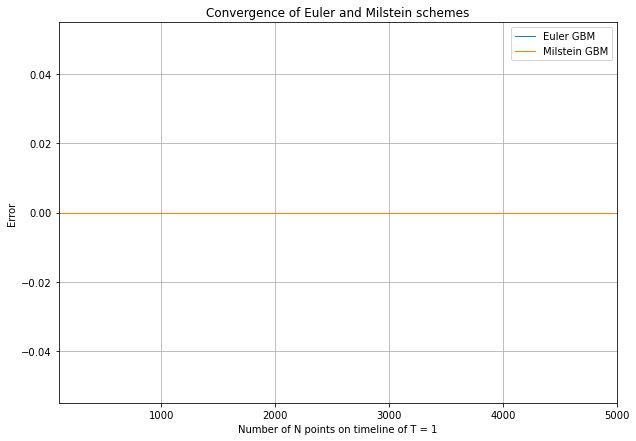

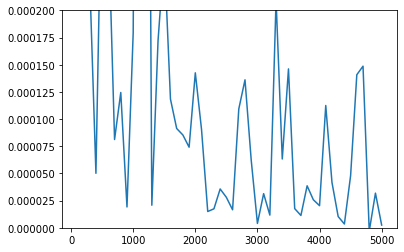

In [8]:
# Plot figure
g = [i for i in range(1, len(N)+1)]
plt.figure ( figsize =(10, 7) )
plt.grid ()

plt.plot (N, terrEU, linewidth =1.0, label="Euler GBM")
plt.plot (N, terrM, linewidth =1.0, label="Milstein GBM")


plt.title ("Convergence of Euler and Milstein schemes")
plt.xlabel ("Number of N points on timeline of T = 1")
plt.ylabel ("Error")
plt.xlim(100, 5000)
#plt.ylim(0,0.01)
plt.legend()
plt.show ()

plt.plot(N, abserr)
plt.ylim(0, 0.0002)
plt.show ()

In [9]:
# Task 5:
#Task 3(5):
# Write a random number generator function for OU, GBM, CIR processes with explicit solution p45
# OU (15, p32), GBM (17, p35), CIR (18, p36)

# Functions for random number generator:
def OU_sample(theta, kappa, sigma, N):
    return rnd.normal(theta/kappa, (sigma**2)/(2*kappa), N)

def GBM_sample(mu, sigma, t, N):
    return np.exp(rnd.normal((mu-(sigma**2)/2)*t, (sigma**2)*t, N))

def CIR_sample(kappa, theta, sigma, S0, t, N):
    #m = kappa / theta + (S0 - kappa / theta) * np.exp(-theta * t)
    #v = S0 * ((sigma**2) * (np.exp(-theta*t) - np.exp(-2*theta*t))/theta) \
    #+ kappa * (sigma**2) / (2*(theta**2)) * (1 - np.exp(-2*theta*t))
    #return rnd.normal(m, v, N)
    return rnd.gamma(2*kappa/(sigma**2), (sigma**2)/(2*theta), N)

In [10]:
# Data:
theta = 0.5
kappa = 0.75
mu    = 0.2
sigma = 0.2
N     = 1000
t     = 1
S0    = 10

ou_sample  = OU_sample(theta, kappa, sigma, N)
gbm_sample = GBM_sample(mu, sigma, t, N)
cir_sample = CIR_sample(kappa, theta, sigma, S0, t, N)

In [11]:
import csv

with open('processes.csv', 'w', newline='') as csvfile:
    fieldnames = ['OU', 'GBM', 'CIR']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(ou_sample)):
        writer.writerow({'OU': ou_sample[i], 'GBM': gbm_sample[i], 'CIR': cir_sample[i]})

In [12]:
import pandas as pd

In [13]:
# Auxiliary functions:
def Density_bins(A, bins):
    A = A.to_numpy()
    A.sort()
    min_A, max_A = A[0], A[len(A) - 1]
    interval, step = np.linspace(min_A, max_A, bins, retstep=True)
    j = 0
    hist = []
    for i in interval:
        c = 0
        for k in range(j, len(A)):
            if ((A[k] > i) and (A[k] < (i+step))):
                c += 1
        j =+ c
        hist.append([i+step/2, c])
    hist = np.array(hist)
    hist = hist.reshape(-1).reshape(bins, 2)
    return hist

In [14]:
# Task 5: 
# Generate trajectories for the previous processes and plot:
# a) cumulative distribution, b) density function, 
# c) calculate the 90%-quantile for the realisation of three processes

gen_paths = pd.read_csv('processes.csv')
gen_paths['cdf_OU'] = gen_paths['OU'].rank(method = 'average', pct = True)
gen_paths['cdf_GBM'] = gen_paths['GBM'].rank(method = 'average', pct = True)
gen_paths['cdf_CIR'] = gen_paths['CIR'].rank(method = 'average', pct = True)
gen_paths.sort_values('GBM')

,OU,GBM,CIR,cdf_OU,cdf_GBM,cdf_CIR
790,0.676901,1.059645,1.480542,0.652,0.001,0.495
982,0.646128,1.067787,1.586987,0.237,0.002,0.654
346,0.675995,1.070299,1.821466,0.640,0.003,0.892
653,0.653563,1.072600,1.499609,0.334,0.004,0.534
339,0.666140,1.074554,1.163646,0.508,0.005,0.071
...,...,...,...,...,...,...
356,0.645313,1.338220,1.441565,0.225,0.996,0.419
796,0.708146,1.346579,1.284462,0.934,0.997,0.197
28,0.690814,1.347779,1.435118,0.806,0.998,0.411
52,0.604836,1.351007,1.004158,0.007,0.999,0.008


In [15]:
bins = 100
GBM_pdf = Density_bins(gen_paths['GBM'], bins)
OU_pdf = Density_bins(gen_paths['OU'], bins)
CIR_pdf = Density_bins(gen_paths['CIR'], bins)


In [27]:
aa = gen_paths.sort_values('GBM')['GBM']

In [33]:
s.sort_values('cdf_GBM')['cdf_GBM']

790    0.001
982    0.002
346    0.003
653    0.004
339    0.005
       ...  
356    0.996
796    0.997
28     0.998
52     0.999
800    1.000
Name: cdf_GBM, Length: 1000, dtype: float64

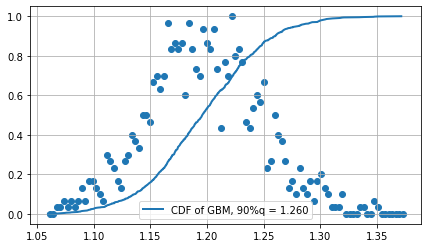

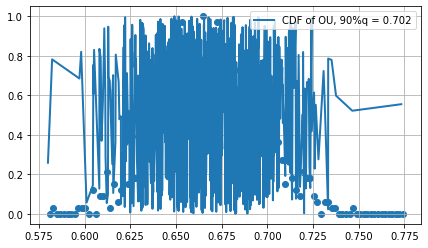

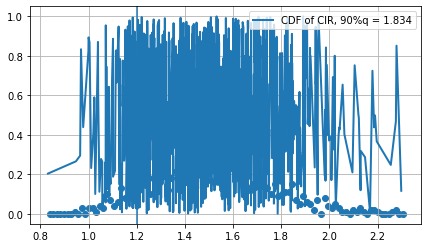

In [36]:
# Plot CDF, PDF
plt.figure ( figsize =(7, 4) )
plt.grid ()

s = gen_paths.sort_values('GBM')
plt.plot (s['GBM'], [i/N for i in range(1, N+1)], linewidth =2.0, label="CDF of GBM, 90%q = {:.3f}".format(gen_paths['GBM'].quantile(0.9)))
plt.scatter(GBM_pdf[:,0], GBM_pdf[:, 1]/GBM_pdf[:,1].max())
plt.legend()
plt.show ()

plt.figure ( figsize =(7, 4) )
plt.grid ()
plt.plot (gen_paths.sort_values('OU')['OU'], gen_paths.sort_values('OU')['cdf_OU'], linewidth =2.0, label="CDF of OU, 90%q = {:.3f}".format(gen_paths['OU'].quantile(0.9)))
plt.scatter(OU_pdf[:,0], OU_pdf[:, 1]/OU_pdf[:,1].max())
plt.legend()
plt.show ()

plt.figure ( figsize =(7, 4) )
plt.grid ()
plt.plot (gen_paths.sort_values('CIR')['CIR'], gen_paths.sort_values('CIR')['cdf_CIR'], linewidth =2.0, label="CDF of CIR, 90%q = {:.3f}".format(gen_paths['CIR'].quantile(0.9)))
#plt.(gen_paths['CIR'].quantile(0.9), 1)
plt.scatter(CIR_pdf[:,0], CIR_pdf[:, 1]/len(CIR_pdf[:,]))
plt.axvline(x=gen_paths['CIR'].quantile(1-0.9), ymin=0, ymax=1)


#plt.title ("Convergence of Euler and Milstein schemes")
#plt.xlabel ("Number of N points on timeline of T = 1")
#plt.ylabel ("Error")
#plt.xlim(100, 5000)
#plt.ylim(0,0.01)
plt.legend()
plt.show ()

In [21]:
#Task 3:
# Write a random number generator function for OU, GBM, CIR processes with explicit solution p45
# OU (15, p33), GBM (17, p35), CIR (18, p36)

# Functions for random number generator:
def OU_gen(theta, kappa, sigma, S, t):
    cond_m = kappa / theta + (S - kappa / theta) * np.exp(-theta * t)
    cond_v = (sigma**2) / (2 * theta) * (1 - np.exp(-2 * theta * t))
    return rnd.normal(cond_m, np.sqrt(cond_v))

def OU(S, theta, kappa, sigma, dt, dW):
    dS = (kappa - theta * S) * dt + sigma * dW
    return dS

def GBM_gen(mu, sigma, S, t):
    cond_m = S * np.exp(mu * t)
    cond_v = (S**2) * np.exp(2 * mu * t) * (np.exp((sigma**2) * t) - 1)
    return rnd.normal(cond_m, np.sqrt(cond_v))

def CIR_gen(kappa, theta, sigma, S, t):
    cond_m =  kappa / theta + (S - kappa / theta) * np.exp(-theta * t)
    cond_v = S * (sigma**2) * (np.exp(-theta * t) - np.exp(-2 * theta * t)) / theta \
    + kappa * (sigma**2) / (2 * (theta**2)) * (1 - np.exp(-2 * theta * t))
    return rnd.normal(cond_m, np.sqrt(cond_v))

def GBM_s_gen(mu, sigma, S, t):
    return S * np.exp(rnd.normal((mu-(sigma**2)/2)*t, (sigma**2)*t))

In [18]:
time_line[int(N/2)]
print(int(N/2))

500


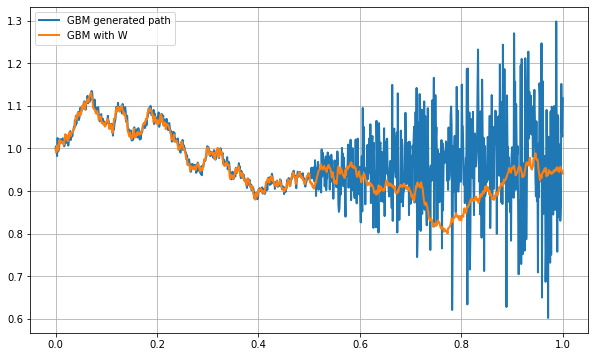

NameError: name 'Density_bins_np' is not defined

In [19]:
# Data:
N = 1000
T = 1
time_line, dt = np.linspace(0, T, N, retstep=True)
mu = 0.1
sigma = 0.2
kappa = 0.65
theta = 0.35

W = Wiener_proc(N, T)

dgbm, dou, dcir = np.zeros(N), np.zeros(N), np.zeros(N)
dgbm[0], dou[0], dcir[0] = 1, 1, 1
ou, gbm, cir = np.zeros(N), np.zeros(N), np.zeros(N)
ou[0], gbm[0], cir[0] = 1, 1, 1

for i in range(1, N):
    #ou[i]  = OU_gen(theta, kappa, sigma, ou[0], time_line[i])
    dW = W[i] - W[i-1]
    
    dgbm[i] = dgbm[i-1] + GBM(dgbm[i-1], mu, sigma, dt, dW)
    gbm[i]  = GBM_gen(mu, sigma, dgbm[i-1], dt)
    if (i > int(N/2)):
        gbm[i]  = GBM_gen(mu, sigma, dgbm[int(N/2)], time_line[i-int(N/2)])
    #gbm[i]  = GBM_gen(mu, sigma, dgbm[0], time_line[i])
    
    dou[i] = dou[i-1] + OU(dou[i-1], theta, kappa, sigma, dt, dW)
    #ou[i]  = OU_gen(theta, kappa, sigma, dou[i-1], dt)
    ou[i]  = OU_gen(theta, kappa, sigma, dou[0], time_line[i])
    
    dcir[i] = dcir[i-1] + CIR(dcir[i-1], kappa, theta, sigma, dt, dW)
    cir[i]  = CIR_gen(kappa, theta, sigma, dcir[0], time_line[i])
    #cir[i]  = CIR_gen(kappa, theta, sigma, dcir[i], dt)
    
    
plt.figure ( figsize =(10, 6) )
plt.grid ()
plt.plot (time_line, gbm, linewidth =2.0, label="GBM generated path")
plt.plot (time_line, dgbm, linewidth =2.0, label="GBM with W")
plt.legend()
plt.show ()

gbmpdf = Density_bins_np(gbm, 50)
plt.figure ( figsize =(10, 6) )
plt.grid ()
plt.plot(np.sort(gbm), [i/N for i in range(N)], linewidth =2.0, label="CDF for GBM generator")
plt.scatter(gbmpdf[:,0], gbmpdf[:,1]/len(gbmpdf[:,]))
plt.legend()
plt.show ()

In [29]:
# Auxiliary functions:
def Density_bins_np(A, bins):
    A.sort()
    min_A, max_A = A[0], A[len(A) - 1]
    interval, step = np.linspace(min_A, max_A, bins, retstep=True)
    j = 0
    hist = []
    for i in interval:
        c = 0
        for k in range(j, len(A)):
            if ((A[k] > i) and (A[k] < (i+step))):
                c += 1
        j =+ c
        hist.append([i+step/2, c])
    hist = np.array(hist)
    hist = hist.reshape(-1).reshape(bins, 2)
    return hist

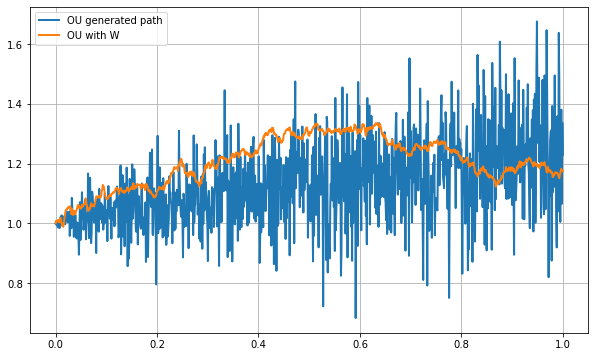

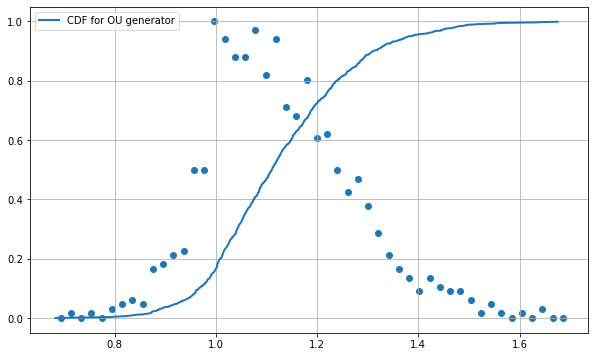

In [40]:
# OU process:
plt.figure ( figsize =(10, 6) )
plt.grid ()
plt.plot (time_line, ou, linewidth =2.0, label="OU generated path")
plt.plot (time_line, dou, linewidth =2.0, label="OU with W")
plt.legend()
plt.show ()

oupdf = Density_bins_np(ou, 50)
plt.figure ( figsize =(10, 6) )
plt.grid ()
plt.plot(np.sort(ou), [i/N for i in range(N)], linewidth =2.0, label="CDF for OU generator")
plt.scatter(oupdf[:,0], oupdf[:,1]/oupdf[:,1].max())
plt.legend()
plt.show ()

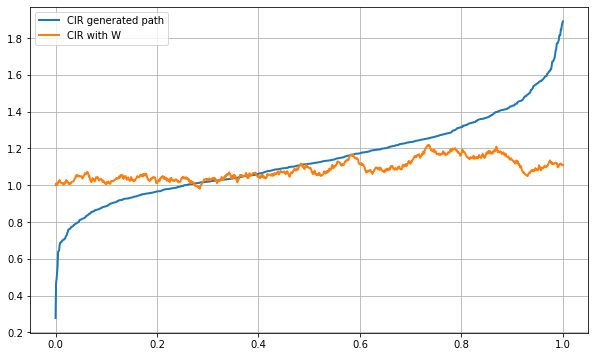

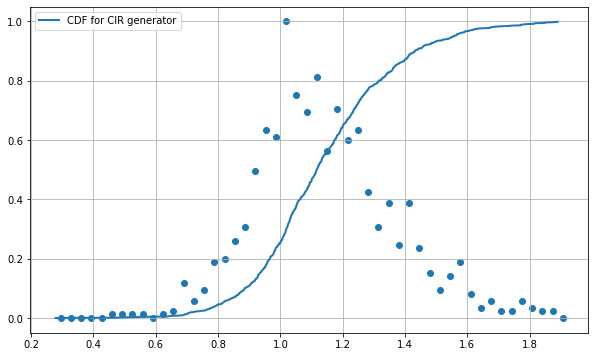

In [37]:
# CIR process:
plt.figure ( figsize =(10, 6) )
plt.grid ()
plt.plot (time_line, cir, linewidth =2.0, label="CIR generated path")
plt.plot (time_line, dcir, linewidth =2.0, label="CIR with W")
plt.legend()
plt.show ()

cirpdf = Density_bins_np(cir, 50)
plt.figure ( figsize =(10, 6) )
plt.grid ()
plt.plot(np.sort(cir), [i/N for i in range(N)], linewidth =2.0, label="CDF for CIR generator")
plt.scatter(cirpdf[:,0], cirpdf[:,1]/cirpdf[:,1].max())
plt.legend()
plt.show ()

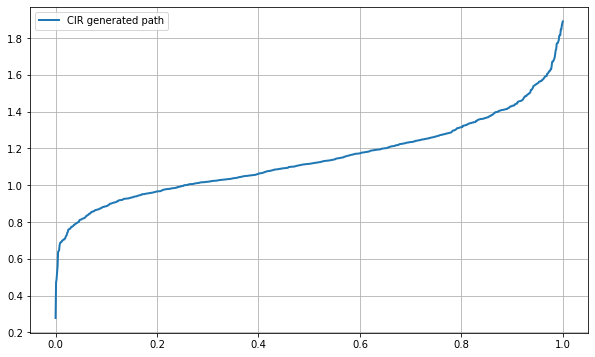

In [36]:
# CIR process:
plt.figure ( figsize =(10, 6) )
plt.grid ()
plt.plot (time_line, cir, linewidth =2.0, label="CIR generated path")
plt.legend()
plt.show ()

In [33]:
with open('processes.csv', 'w', newline='') as csvfile:
    fieldnames = ['OU', 'GBM', 'CIR']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(ou)):
        writer.writerow({'OU': ou[i], 'GBM': gbm[i], 'CIR': cir[i]})